In [1]:
import numpy as np
import binary_dude as bd
import matplotlib.pyplot as plt
%matplotlib inline 

from numpy import *

import keras

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adadelta
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# n=1000000
alpha=0.1
delta=0.1
nb_classes=2
L=np.array([[delta, -delta/(1-2*delta), (1-delta)/(1-2*delta)],[delta, (1-delta)/(1-2*delta), -delta/(1-2*delta)]])
L_new=-L+(1-delta)/(1-2*delta)     # A new loss matrix
k_max=40

print L_new

# -----------------------------------------------------
# For directly loading an image data 
# and generating noisy version of it
# -----------------------------------------------------
from PIL import Image
# im=Image.open('lena_512.tif').convert('L')
im=Image.open('Einstein256_256.jpg').convert('L')
# im=Image.open('barbara.png').convert('L')
# im=Image.open('Shannon256_256.jpg').convert('L')

# im=Image.open('Cameraman.png').convert('L')
# im=Image.open('Boats.png').convert('L')


imarray=np.array(im)
n=imarray.shape[0]*imarray.shape[1]

im_bin=bd.make_binary_image(imarray)
x=im_bin.copy().reshape(n,)
z=bd.bsc(x,delta)
# -----------------------------------------------------
# Save the clean and noisy data
# -----------------------------------------------------

np.savez('Einstein_NIPS_camera_data',x=x,z=z)
# -----------------------------------------------------
# For loading pre-generated data
# -----------------------------------------------------
# npzfile = np.load('lena_image.npz')
# x=npzfile['x']
# z=npzfile['z']
# -----------------------------------------------------

n=x.shape[0]

[[ 1.025  1.25   0.   ]
 [ 1.025  0.     1.25 ]]


In [3]:
Z=np_utils.to_categorical(z,nb_classes)
err_nn_k=zeros(k_max)
err_dude_k=zeros(k_max)

err_dude_k[0]=delta
err_nn_k[0]=delta

est_loss=zeros((2,k_max))
est_loss[0,0]=0.1
est_loss[1,0]=0.1

In [4]:
x_hat_dude=np.zeros((k_max,n))
x_hat_n_dude=np.zeros((k_max,n))

In [5]:
k_range=range(1,k_max+1)
print k_range

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [6]:
# for k in range(1,k_max):
for k in k_range:
    print 'k=',k

# -----------------------------------------------------
# For directly generating data for Neural DUDE
# -----------------------------------------------------
    C,Y = bd.make_data_for_ndude(Z,k,L_new,nb_classes,n)
# -----------------------------------------------------

# -----------------------------------------------------
# For loading pre-generated data for Neural DUDE
# -----------------------------------------------------
#     file_n='lena_nn_k_'+str(k)+'.npz'
#     nn_data=np.load(file_n)
#     C=nn_data['C']
#     Y=nn_data['Y']
# -----------------------------------------------------
    

# -----------------------------------------------------
# Defining neural networks
# -----------------------------------------------------
    model=Sequential()
    model.add(Dense(40,input_dim=2*k*nb_classes,init='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(40,init='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(40,init='he_normal'))
    model.add(Activation('relu'))
#     model.add(Dense(40,init='he_normal'))
#     model.add(Activation('relu'))
    model.add(Dense(3,init='he_normal'))
    model.add(Activation('softmax'))

    rms=RMSprop(lr=0.001, rho=0.9, epsilon=1e-06,clipnorm=1.5)
    adagrad=Adagrad(clipnorm=1.5)
    adam=Adam()
    adadelta=Adadelta()
    sgd=SGD(lr=0.01,decay=1e-6,momentum=0.95, nesterov=True, clipnorm=1.0)
    
    model.compile(loss='poisson', optimizer=adam)
    
    print 'Model fitting...'
    model.fit(C,Y,nb_epoch=10,batch_size=100,show_accuracy=True, verbose=0,
          validation_data=(C, Y))
# -----------------------------------------------------
    
    pred_class=model.predict_classes(C, batch_size=200, verbose=0)
    s_nn_hat=hstack((zeros(k),pred_class,zeros(k)))
    x_nn_hat=bd.denoise_with_s(z,s_nn_hat,k)
    error_nn=bd.error_rate(x,x_nn_hat)
    print 'error_nn=', error_nn
    err_nn_k[k]=error_nn
    
    x_hat_n_dude[k,:]=x_nn_hat
    
    
    s_hat,m= bd.dude2(z,k,delta) 
    x_dude_hat=bd.denoise_with_s(z,s_hat,k)
    error_dude=bd.error_rate(x,x_dude_hat)
    print 'error_dude=',error_dude
    err_dude_k[k]=error_dude
    
    x_hat_dude[k,:]=x_dude_hat
    
    s_class=3
    s_hat_cat=np_utils.to_categorical(s_hat,s_class)
    s_nn_hat_cat=np_utils.to_categorical(s_nn_hat,s_class)
    
    emp_dist=dot(Z,L)
    est_loss_dude=mean(sum(emp_dist*s_hat_cat,axis=1))
    est_loss_nn_dude=mean(sum(emp_dist*s_nn_hat_cat,axis=1))
    
    est_loss[0,k]=est_loss_dude
    est_loss[1,k]=est_loss_nn_dude

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, kernel_initializer="he_normal", input_dim=4)`
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, kernel_initializer="he_normal")`
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, kernel_initializer="he_normal")`


k= 1
Model fitting...

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="he_normal")`
//anaconda/lib/python2.7/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


TypeError: Unrecognized keyword arguments: {'show_accuracy': True}

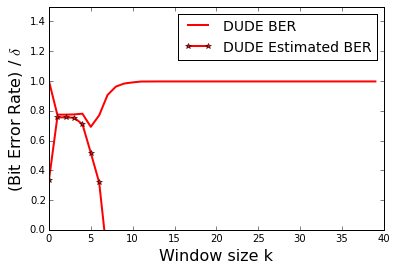

In [13]:
k=range(k_max)
plt.plot(k,err_dude_k/delta,'r',linewidth=2.0)
plt.plot(k,est_loss[0,:]/delta,'r-*',linewidth=2.0)
# plt.plot(k,0.558*np.ones(15),'k',linewidth=2.0)
plt.ylim((0,1.5))
plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
plt.legend(['DUDE BER','DUDE Estimated BER'],loc='upper right',fontsize=14)
# plt.savefig('/Users/tsmoon/Dropbox/Professional/Research/1. Papers/2016/ICML/Neural universal denoiser/figures/Einstein_dude_est_ber.pdf')

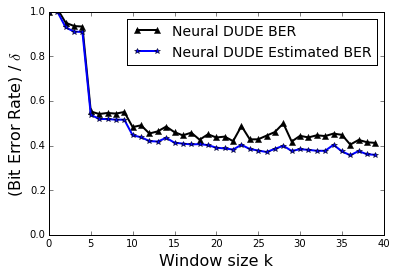

In [11]:
k=range(k_max)
plt.plot(k,err_nn_k/delta,'k-^',linewidth=2.0)
plt.plot(k,est_loss[1,:]/delta,'b-*',linewidth=2.0)
# plt.plot(k,0.558*np.ones(15),'k',linewidth=2.0)
plt.ylim((0,1))
plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
plt.legend(['Neural DUDE BER','Neural DUDE Estimated BER'],loc='upper right',fontsize=14)
# plt.savefig('/Users/tsmoon/Dropbox/Professional/Research/1. Papers/2016/ICML/Neural universal denoiser/figures/Einstein_n_dude_est_ber.pdf')

In [14]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

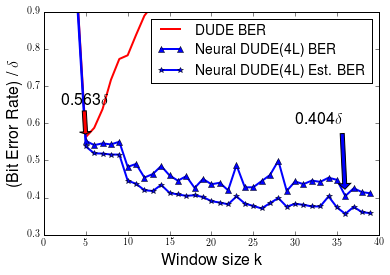

In [16]:
k=range(k_max)
plt.plot(k,err_dude_k/delta,'r',linewidth=2.0)
plt.plot(k,err_nn_k/delta,'b-^',linewidth=2.0)
plt.plot(k,est_loss[1,:]/delta,'b-*',linewidth=2.0)

plt.legend(['DUDE BER','Neural DUDE(4L) BER','Neural DUDE(4L) Est. BER'],fontsize=14)
plt.ylim((0.3,0.9))
plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
plt.annotate('0.404$\delta$', xy=(36, 0.404), xytext=(30, 0.6),
            arrowprops=dict(facecolor='blue', shrink=0.1),fontsize=16
            )
plt.annotate('0.563$\delta$', xy=(5, 0.563), xytext=(2, 0.65),
            arrowprops=dict(facecolor='red', shrink=0.1),fontsize=16
            )
plt.savefig('/Users/tsmoon/Dropbox/Professional/Research/1. Papers/2016/NIPS_camera_ready/figures/Einstein_delta_0_1_k_40.pdf')

In [17]:
np.savez('Einstein_NIPS_camera_data',x=x,z=z)

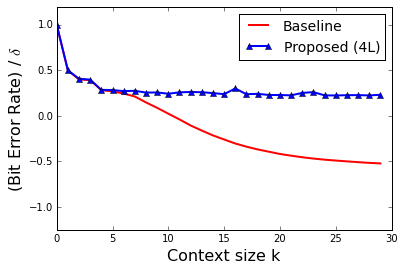

In [10]:
k=range(k_max)
plt.plot(k,est_loss[0,]*10,'r',linewidth=2.0)
plt.plot(k,est_loss[1,]*10,'b-^',linewidth=2.0)
plt.legend(['Baseline','Proposed (4L)'],fontsize=14)
# plt.legend(['DUDE','Neural DUDE (4L)'])

plt.ylim((-1.25,1.2))
plt.xlabel('Context size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
# plt.savefig('lena_est_ber_k_27_nrf.pdf')

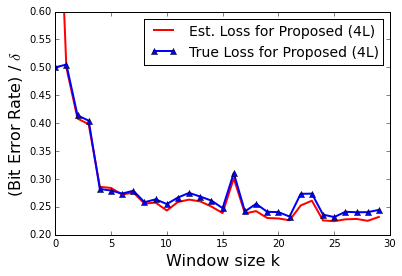

In [12]:
k=range(k_max)
plt.plot(k,est_loss[1,]*10,'r',linewidth=2.0)
plt.plot(k,err_nn_k*10,'b-^',linewidth=2.0)
plt.ylim((0.2,0.6))
plt.legend(['Est. Loss for Proposed (4L)','True Loss for Proposed (4L)'],fontsize=14)
# plt.legend(['Est. Loss for Neural DUDE (4L)','True Loss for Neural DUDE (4L)'])

plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
# plt.savefig('lena_est_true_ber_neural_dude_nrf.pdf')

In [16]:
#res_file='Neural_dude_result_full'
#np.savez(res_file,est_loss=est_loss,err_nn_k=err_nn_k,err_dude_k=err_dude_k)

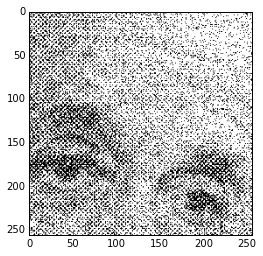

In [8]:
plt.imshow(x_dude_hat.reshape((256,256)),cmap=plt.cm.gray)

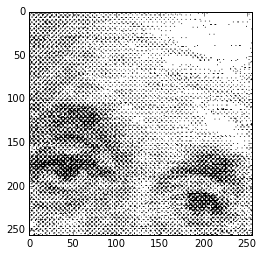

In [9]:
plt.imshow(x_nn_hat.reshape((256,256)),cmap=plt.cm.gray)

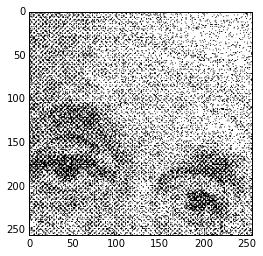

In [10]:
plt.imshow(z.reshape((256,256)),cmap=plt.cm.gray)

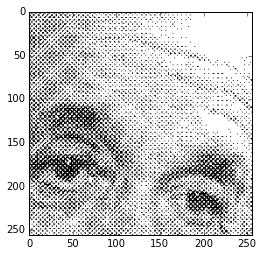

In [11]:
plt.imshow(x.reshape((256,256)),cmap=plt.cm.gray)

In [108]:
res_file='result_Shannon_delta_0_15_k_40'
np.savez(res_file,est_loss=est_loss,err_nn_k=err_nn_k,err_dude_k=err_dude_k)